In [1]:
from ay_torch import *

# Nonlinear regression with Res blocks

In [2]:
FUNC_KIND=3
def Func(x):
  #NOTE: Switch the function to be learned.
  global FUNC_KIND
  if FUNC_KIND==0:  return x
  if FUNC_KIND==1:  return (x[:,0]**2).reshape((-1,1))
  if FUNC_KIND==2:  return (3.0-x[:,0]).reshape((-1,1))
  if FUNC_KIND==3:  return (x[:,0]+3.0*np.sin(x[:,0])).reshape((-1,1))
  if FUNC_KIND==4:  return np.where(x[:,0]**2<1.0, 3.0, 0.0).reshape((-1,1))

def GenerateSample(xmin, xmax, N_sample, f, noise=1.0e-10):
  data_x= np.random.uniform(xmin,xmax,size=(N_sample,1))
  data_y= f(data_x) + np.random.normal(scale=noise,size=(N_sample,1))
  return data_x,data_y

In [273]:
xmin,xmax= -5.0, 5.0
N_sample= 50
#NOTE: Adjust the sample size and noise level.
data_x,data_y= GenerateSample(xmin, xmax, N_sample, Func, noise=0.5)

#Convert data to torch variables.
data_x= torch.autograd.Variable(torch.from_numpy(data_x).float())
data_y= torch.autograd.Variable(torch.from_numpy(data_y).float())

#NOTE: Adjust the batch and epoch sizes.
N_batch= 50

#Make torch dataset and loader.
test_ratio= 0.2
idxes= np.random.RandomState(seed=42).permutation(data_x.shape[0])
N_train= round(data_x.shape[0]*(1.-test_ratio))
dset_train= torch.utils.data.TensorDataset(data_x[idxes[:N_train]], data_y[idxes[:N_train]])
dset_test= torch.utils.data.TensorDataset(data_x[idxes[N_train:]], data_y[idxes[N_train:]])
dl_train= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)
dl_test= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
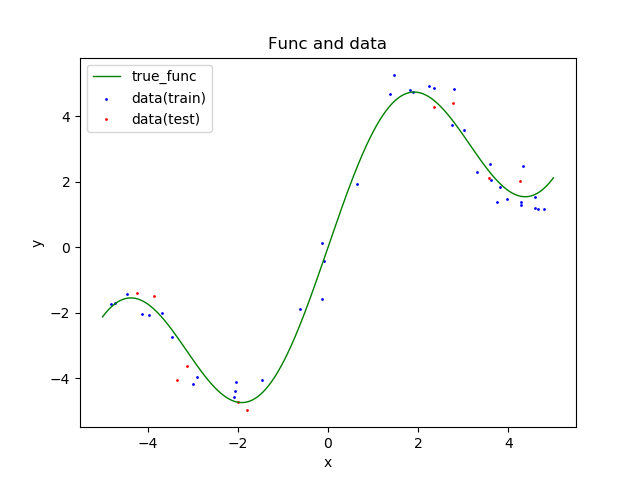

In [274]:
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], s=1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], s=1, color='red', label='data(test)')
ax_pred.legend()

In [234]:
def DefRegNN6(p=0.0, n_hiddens=3):
  hiddens= sum([[torch.nn.Linear(200, 200),
                 torch.nn.ReLU()] for i in range(n_hiddens)],[])
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          *hiddens,
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 1),
          )

def dense_layer(in_channels, out_channels,
              bias=True, norm_type=None, batchnorm_first=True,
              activation=torch.nn.LeakyReLU, init='auto', bias_std=0.5):
  bn= norm_type in ('batch', 'batch_zero')
  inn= norm_type in ('instance', 'instance_zero')
  # if bias is None: bias= not (bn or inn)
  dense= torch.nn.Linear(in_channels, out_channels, bias=bias)
  act= (None if activation is None else 
        activation(inplace=True) if activation in (torch.nn.ReLU,torch.nn.ReLU6,torch.nn.LeakyReLU) else
        activation())
  if getattr(dense,'bias',None) is not None and bias_std is not None:
    if bias_std!=0: torch.nn.init.normal_(dense.bias, 0.0, bias_std)
    else: dense.bias.data.zero_()
  f_init= None
  if act is not None and init=='auto':
    if hasattr(act.__class__, '__default_init__'):
      f_init= act.__class__.__default_init__
    else:  f_init= getattr(act, '__default_init__', None)
    if f_init is None and act in (torch.nn.ReLU,torch.nn.ReLU6,torch.nn.LeakyReLU):
      f_init= torch.nn.init.xavier_uniform_
  if f_init is not None: f_init(dense.weight,gain=torch.nn.init.calculate_gain('leaky_relu'))
  if   norm_type=='weight':   dense= torch.nn.utils.weight_norm(dense)
  elif norm_type=='spectral': dense= torch.nn.utils.spectral_norm(dense)
  layers= [dense]
  act_bn= []
  if act is not None: act_bn.append(act)
  if bn: 
    bnl= torch.nn.BatchNorm1d(out_channels)
    if bnl.affine:
      bnl.bias.data.fill_(1e-3)
      bnl.weight.data.fill_(0. if norm_type=='batch_zero' else 1.)
    act_bn.append(bnl)
  if inn: 
    innl= torch.nn.InstanceNorm1d(out_channels, affine=True)
    if innl.affine:
      innl.bias.data.fill_(1e-3)
      innl.weight.data.fill_(0. if norm_type=='instance_zero' else 1.)
    act_bn.append(innl)
  if batchnorm_first: act_bn.reverse()
  layers+= act_bn
  return torch.nn.Sequential(*layers)

def dense_layer_test(p=0.0, n_hiddens=3, **kwargs):
  hiddens= [dense_layer(200, 200) for i in range(n_hiddens)]
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          *hiddens,
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 1),
          )


class res_dense_block(torch.nn.Module):
  def __init__(self, in_channels, out_channels, 
               hidden_channels=None,
               norm_type=None, activation=torch.nn.LeakyReLU,
               **kwargs):
    super(res_dense_block,self).__init__()
    norm2= ('batch_zero' if norm_type=='batch' else
            'instance_zero' if norm_type=='instance' else norm_type)
    if hidden_channels is None: hidden_channels= out_channels
    kwargs1= dict(norm_type=norm_type, activation=activation, **kwargs)
    kwargs2= dict(norm_type=norm2, activation=None, **kwargs)
    densepath= [dense_layer(in_channels, hidden_channels, **kwargs1),
                dense_layer(hidden_channels, out_channels, **kwargs2)]
    self.densepath= torch.nn.Sequential(*densepath)
    idpath= []
    if in_channels!=out_channels: idpath.append(dense_layer(in_channels, out_channels, activation=None, **kwargs))
    self.idpath= torch.nn.Sequential(*idpath)
    self.act= activation(inplace=True) if activation in (torch.nn.ReLU,torch.nn.ReLU6,torch.nn.LeakyReLU) else activation()

  def forward(self, x): 
    return self.act(self.densepath(x) + self.idpath(x))


def noop(x):  return x

class res_dense_net(torch.nn.Module):
  def __init__(self, in_channels, out_channels, p=0.0, hidden_channels=10, n_hiddens=3):
    super(res_dense_net,self).__init__()
    hiddens= [res_dense_block(hidden_channels, hidden_channels) for i in range(n_hiddens)]
    self.net= torch.nn.Sequential(
          torch.nn.Linear(in_channels, hidden_channels),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          *hiddens,
          torch.nn.Dropout(p),
          torch.nn.Linear(hidden_channels, out_channels),
          )
  def forward(self, x):
    return self.net(x)


In [235]:
# ConvLayer(3, 4, kernel_size=3)
dense_layer(3,4)

Sequential(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace=True)
)

In [288]:
#Setup a neural network.
net= DefRegNN6(n_hiddens=10, p=0.0)

device= torch.device('cpu')
# device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return torch.autograd.Variable(x), torch.autograd.Variable(y)
logger= TLogger()
disp= TDisp()

In [289]:
torchinfo.summary(net)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            400
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            40,200
├─ReLU: 1-5                              --
├─Linear: 1-6                            40,200
├─ReLU: 1-7                              --
├─Linear: 1-8                            40,200
├─ReLU: 1-9                              --
├─Linear: 1-10                           40,200
├─ReLU: 1-11                             --
├─Linear: 1-12                           40,200
├─ReLU: 1-13                             --
├─Linear: 1-14                           40,200
├─ReLU: 1-15                             --
├─Linear: 1-16                           40,200
├─ReLU: 1-17                             --
├─Linear: 1-18                           40,200
├─ReLU: 1-19                             --
├─Linear: 1-20                        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
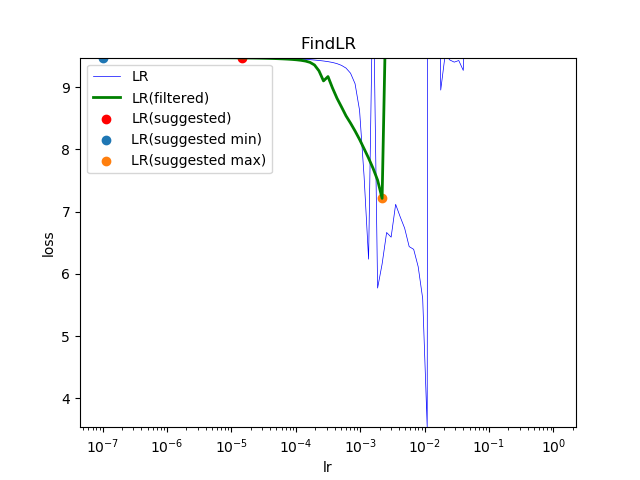

lr= 1.4791083881682072e-05, lr_min=1e-07, lr_max=0.0021877616239495525


In [290]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
20	7.16009045	7.16005564	2.67582798	0.306422
21	7.16005468	7.07449579	2.65979242	0.292222
22	7.07449484	6.71061230	2.59048486	0.273230
23	6.71061230	5.82594824	2.41370010	0.285588
24	5.82594872	4.28843594	2.07085395	0.312927
25	4.28843594	5.31803513	2.30608654	0.312368
26	5.31803608	4.93922758	2.22243738	0.296730
27	4.93922758	3.89392471	1.97330296	0.293752
28	3.89392424	3.87739325	1.96910977	0.280775
29	3.87739325	4.12324429	2.03057742	0.317651
30	4.12324429	4.18926239	2.04676867	0.297138
31	4.18926191	4.06858587	2.01707363	0.323723
32	4.06858587	3.88278913	1.97047937	0.294430
33	3.88278890	3.75906825	1.93883169	0.278226
34	3.75906825	3.70082402	1.92375255	0.295627
35	3.70082426	3.63677859	1.90703392	0.312600
36	3.63677859	3.55904722	1.88654375	0.300886
37	3.55904722	3.49799848	1.87029374	0.287642
38	3.49799800	3.46601868	1.86172462	0.298138
39	3.46601868	3.45704341	1.85931265	0.338379


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
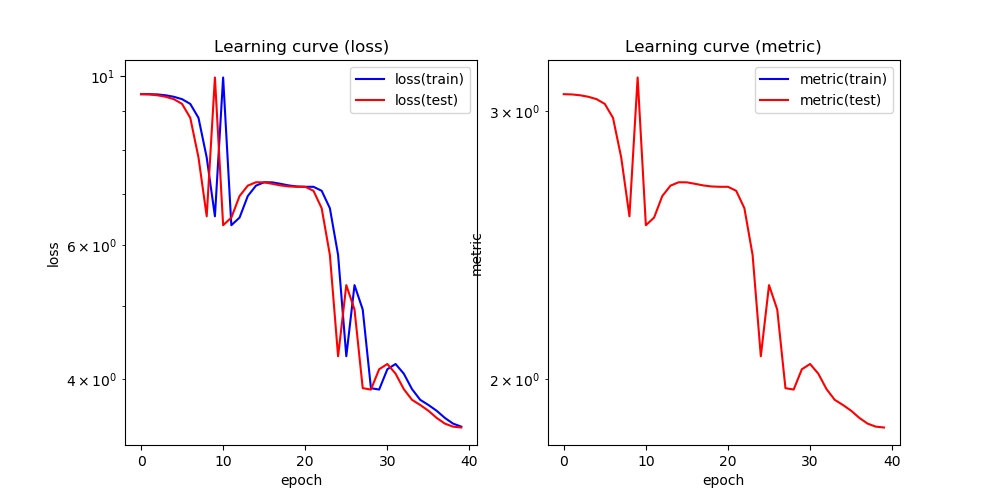

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
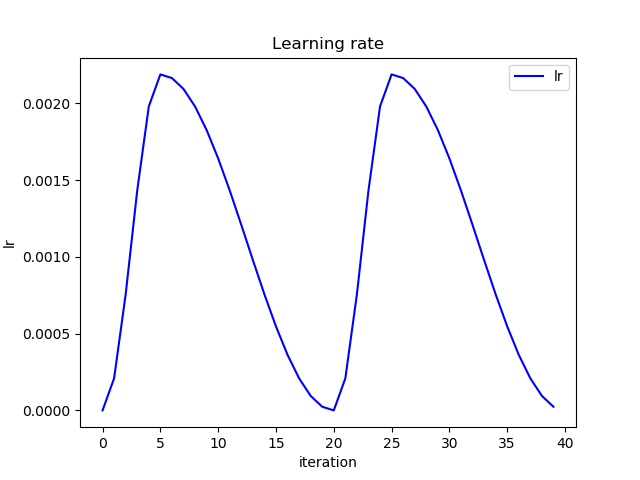

In [293]:
FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
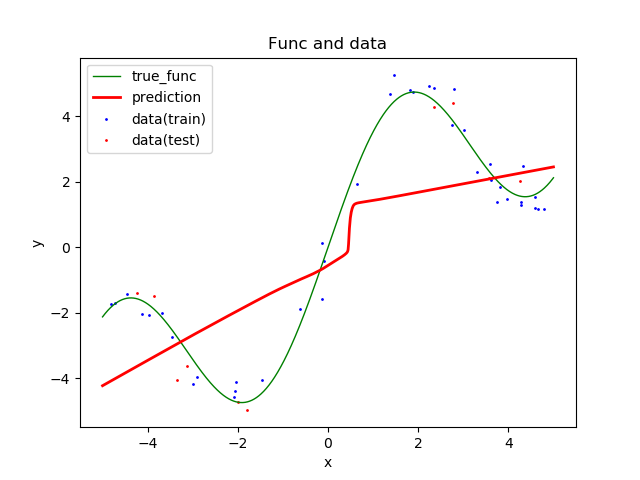

In [294]:
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
pred_y= decode(Eval(net, torch.from_numpy(true_x).float(), device=device)).cpu()
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], s=1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], s=1, color='red', label='data(test)')
ax_pred.plot(true_x, pred_y, color='red', linewidth=2, label='prediction')
ax_pred.legend()

In [313]:
#Setup a neural network.
# net= dense_layer_test(norm_type=None, init='auto', bias_std=0.5)
# net= dense_layer_test(n_hiddens=10)
# net= res_dense_net(1, 1, hidden_channels=10)
# net= res_dense_net(1, 1, hidden_channels=100)
net= res_dense_net(1, 1, hidden_channels=200, n_hiddens=10, p=0.0)

device= torch.device('cpu')
# device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= torch.nn.MSELoss()

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return torch.autograd.Variable(x), torch.autograd.Variable(y)
logger= TLogger()
disp= TDisp()

In [314]:
# net
torchinfo.summary(net)

Layer (type:depth-idx)                        Param #
res_dense_net                                 --
├─Sequential: 1-1                             --
│    └─Linear: 2-1                            400
│    └─ReLU: 2-2                              --
│    └─Dropout: 2-3                           --
│    └─res_dense_block: 2-4                   --
│    │    └─Sequential: 3-1                   80,400
│    │    └─Sequential: 3-2                   --
│    │    └─LeakyReLU: 3-3                    --
│    └─res_dense_block: 2-5                   --
│    │    └─Sequential: 3-4                   80,400
│    │    └─Sequential: 3-5                   --
│    │    └─LeakyReLU: 3-6                    --
│    └─res_dense_block: 2-6                   --
│    │    └─Sequential: 3-7                   80,400
│    │    └─Sequential: 3-8                   --
│    │    └─LeakyReLU: 3-9                    --
│    └─res_dense_block: 2-7                   --
│    │    └─Sequential: 3-10                  80,40

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
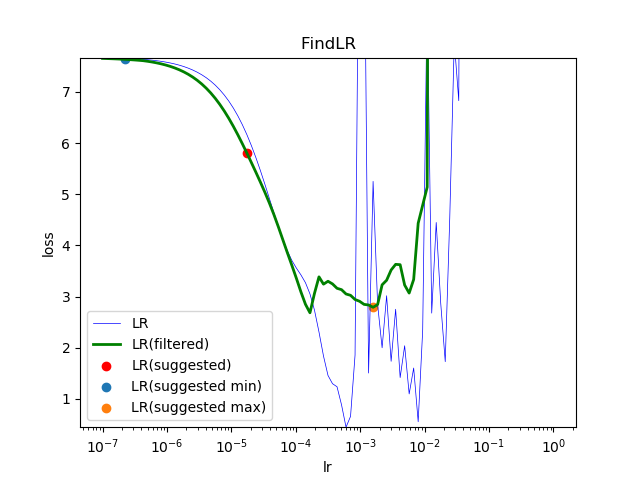

lr= 1.7378008287493757e-05, lr_min=2.2387211385683399e-07, lr_max=0.001584893192461113


In [315]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
40	0.34838945	0.34829709	0.59016699	0.341488
41	0.34829712	0.29177517	0.54016215	0.363440
42	0.29177517	0.27955741	0.52873188	0.358948
43	0.27955738	0.75607866	0.86952782	0.324576
44	0.75607872	1.14619565	1.07060528	0.317352
45	1.14619589	0.70127261	0.83742023	0.355356
46	0.70127261	0.34448925	0.58693206	0.313272
47	0.34448928	0.53966039	0.73461580	0.342093
48	0.53966045	0.63309890	0.79567510	0.316385
49	0.63309878	0.44821781	0.66949069	0.351818
50	0.44821781	0.27332473	0.52280468	0.337077
51	0.27332476	0.24512163	0.49509761	0.330023
52	0.24512163	0.30518621	0.55243659	0.340551
53	0.30518621	0.34572840	0.58798671	0.326505
54	0.34572843	0.33196807	0.57616669	0.351017
55	0.33196810	0.29070249	0.53916836	0.320739
56	0.29070246	0.25168177	0.50167894	0.323399
57	0.25168177	0.22659484	0.47601977	0.348277
58	0.22659484	0.21474206	0.46340269	0.320796
59	0.21474206	0.21157198	0.45996955	0.362286


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
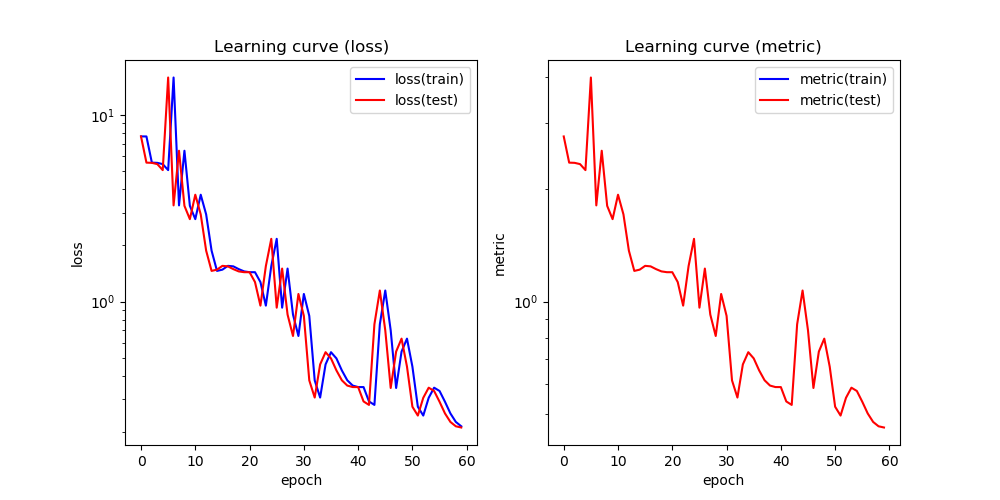

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
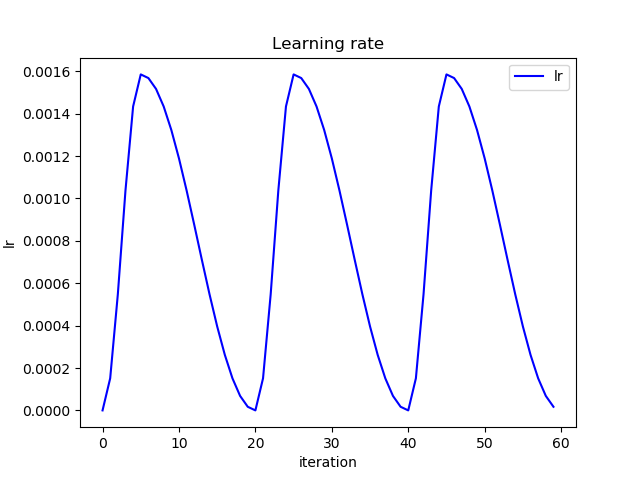

In [319]:
FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
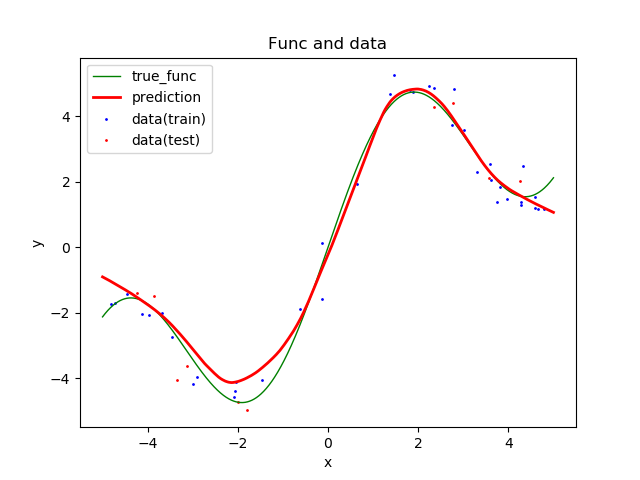

In [320]:
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
pred_y= decode(Eval(net, torch.from_numpy(true_x).float(), device=device)).cpu()
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], s=1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], s=1, color='red', label='data(test)')
ax_pred.plot(true_x, pred_y, color='red', linewidth=2, label='prediction')
ax_pred.legend()